In [3]:
import json
import pandas as pd
from statistics import mean
from collections import Counter
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [6]:
def load_data(path='../data/raw/train.json'):

    with open(path,'r') as file:
        data = json.load(file)

    return data



In [8]:
data = load_data(path = 'data/annotation/master.json' )
#mean([ dp[ 'fleiss-kappa'] for idx,dp in data.items() ])

In [9]:
filepath = "data/labelled_data/"
all_files = os.listdir(filepath)
comments = {}
posts = {}
for fname in tqdm(all_files):
    file = pd.read_csv(filepath+fname,sep='\t').drop('Unnamed: 0',axis=1)
    if 'submission' in fname:
        posts['_'.join(fname.split('_')[3:6])] = file

        
subset = []
for date,df in posts.items():
    df['date'] = date
    subset.append(df)

merged_posts = pd.concat(subset)
  

100%|██████████| 590/590 [00:06<00:00, 84.80it/s]


In [10]:
dims = ['conflict','similarity','knowledge','power','status','support','identity','romance','trust','fun']
scores_per_dim = { dim : [] for dim in dims}
cnt = 0
ids_not_fount= []
for idx, dp in data.items():

    row_df = merged_posts.loc[merged_posts['id'] == dp['id']]
    if row_df.shape[0] == 1:
        temp_dim_cnt = Counter()
        annotator_cnt = len(dp['annotations'])
        for annotator, labels in dp['annotations'].items():
            
            labels =  [lab.lower() for lab in labels]
            temp_dim_cnt.update(labels) 
        
        for dim in dims:
            ann_ratio = 0
            if annotator_cnt != 0:
                ann_ratio = temp_dim_cnt[dim]/annotator_cnt
            
            scores_per_dim[dim].append((row_df[dim].iloc[0], ann_ratio))
    else:
        ids_not_fount.append(dp['id'])

In [11]:
len(scores_per_dim[dims[2]])


187

In [30]:
def annotated_of_dim(dim, scores_per_dim,annotation_ratio  = 0.2):

    dim_list = scores_per_dim[dim]
    included_l = []
    excluded_l = []
    for model_v, ann_v in dim_list: 
        if ann_v >= annotation_ratio:
            included_l.append( model_v )
        else:
            excluded_l.append( model_v)
    
    return included_l, excluded_l



In [33]:
def plot_bar(p_list,title= ''):
    
    pmean = 0
    if p_list:
        pmean = mean(p_list)
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation= 45)
    plt.title(title)
    plt.xlim([0,1])
    plt.hist(p_list,bins=20)
    plt.axvline(pmean, color='red', linestyle='dashed', linewidth=2)
    min_ylim, max_ylim = plt.ylim()
    plt.text(pmean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(pmean))
    plt.show()
    plt.clf()

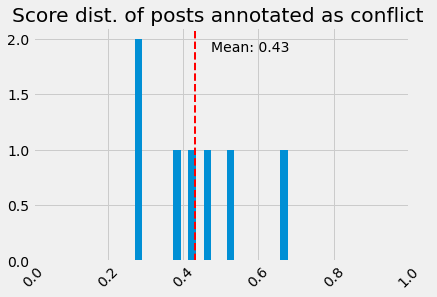

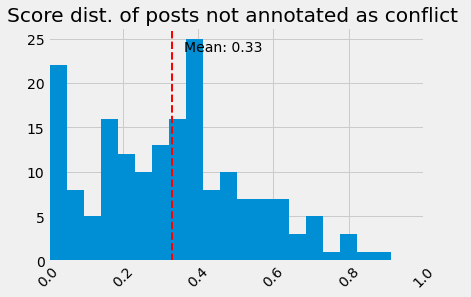

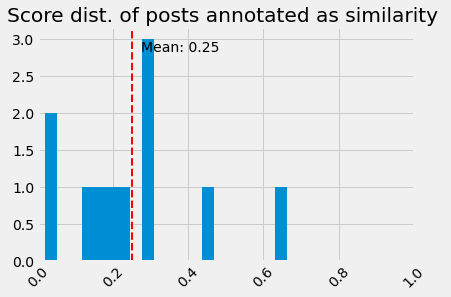

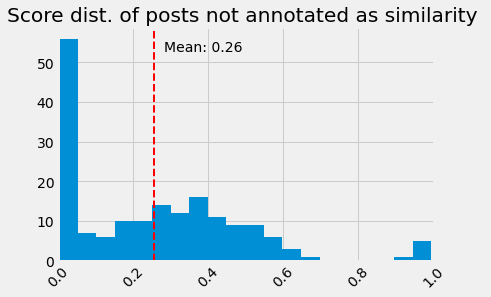

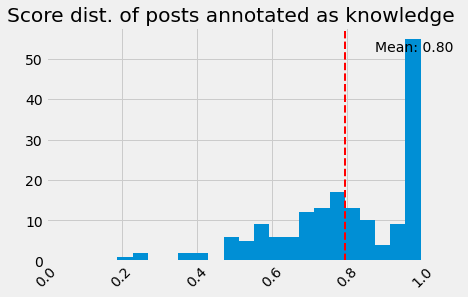

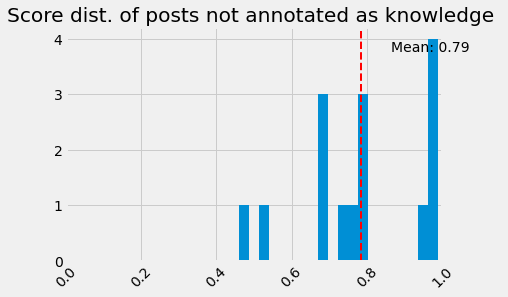

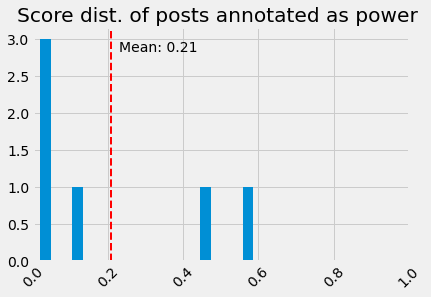

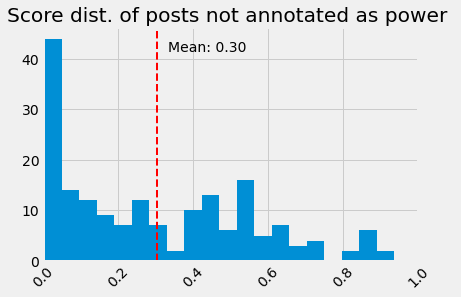

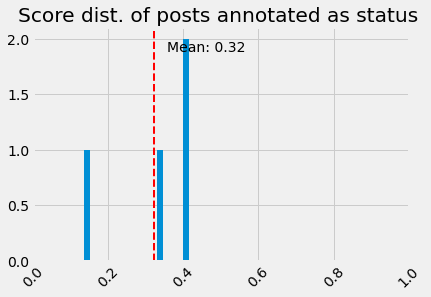

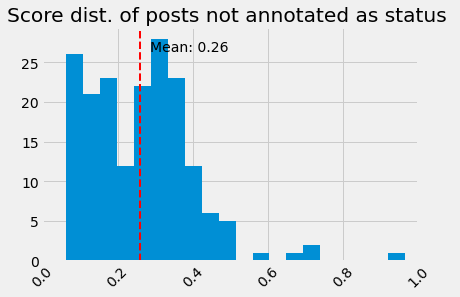

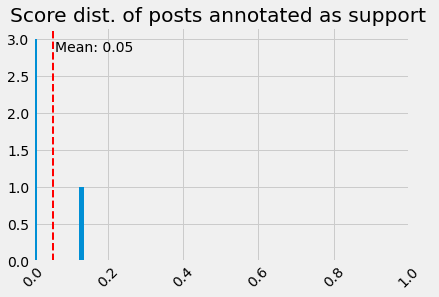

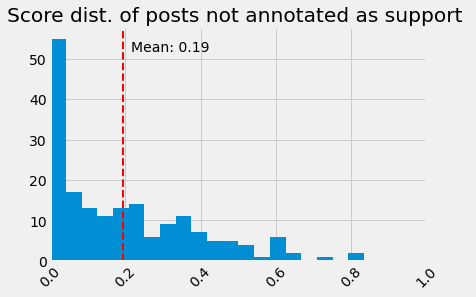

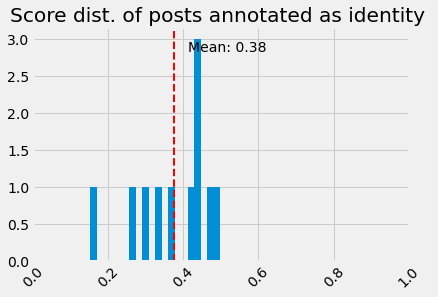

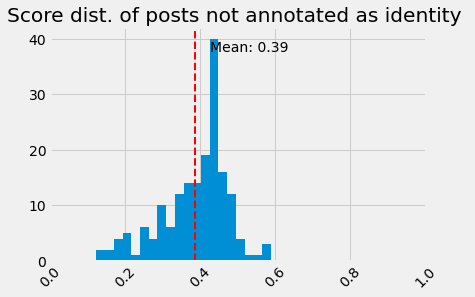

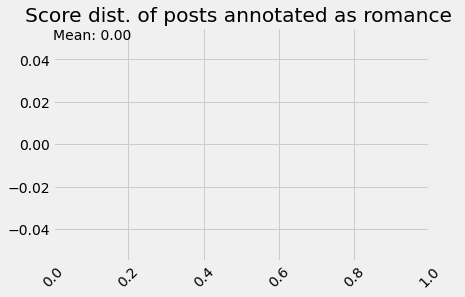

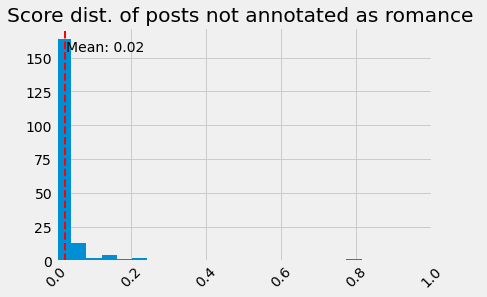

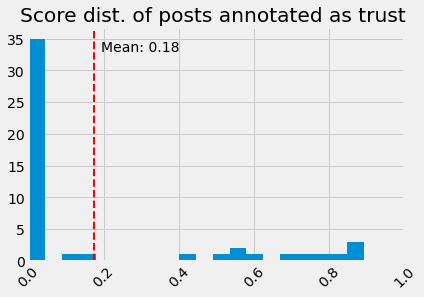

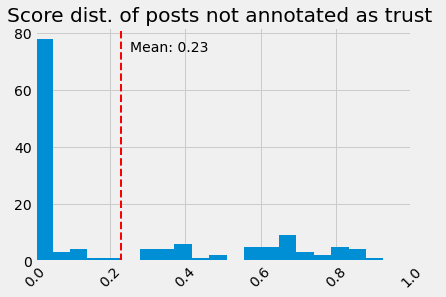

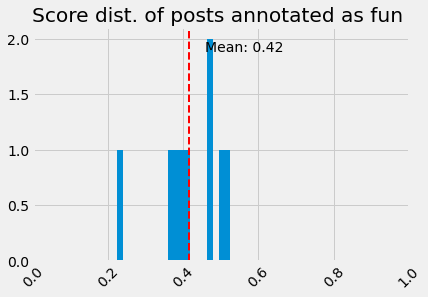

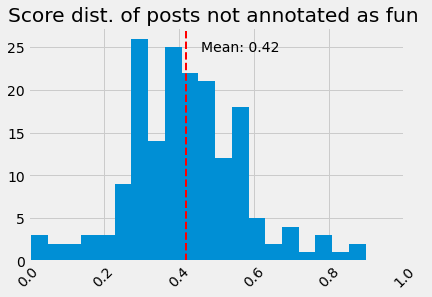

<Figure size 432x288 with 0 Axes>

In [35]:

for dim in dims:
    #print(dim)
    ann_list,other_list = annotated_of_dim(dim, scores_per_dim, annotation_ratio= 0.5)
    
    #print( "Trash hold: ", trash_hold, "Other values average: ", other_avg)
    plot_bar(ann_list, title = f'Score dist. of posts annotated as {dim} ')
    plot_bar(other_list, title= f'Score dist. of posts not annotated as {dim} ')


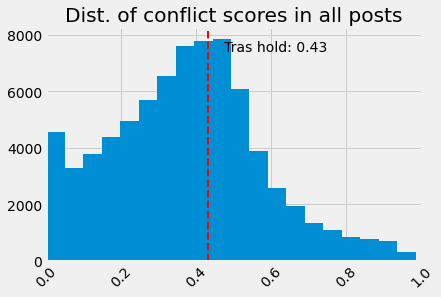

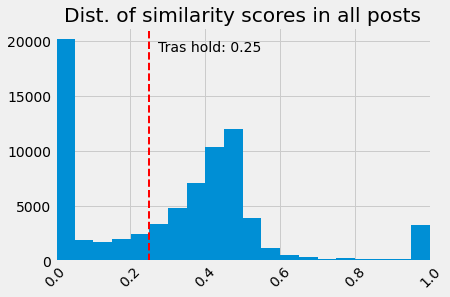

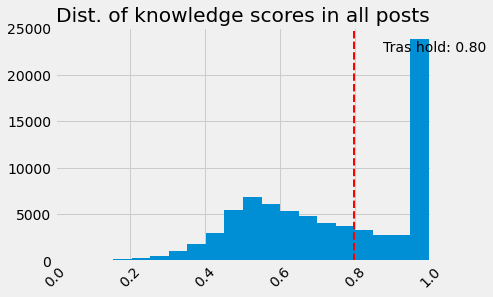

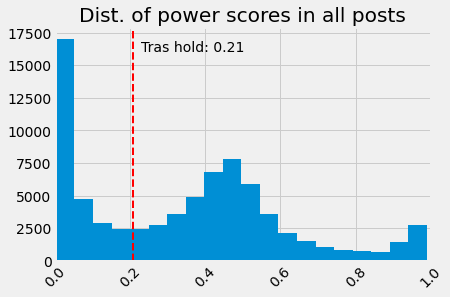

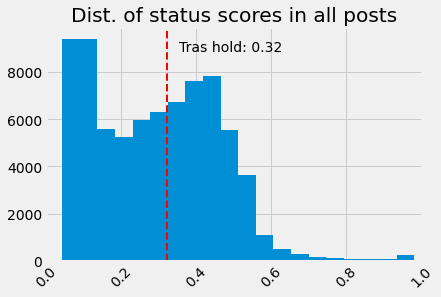

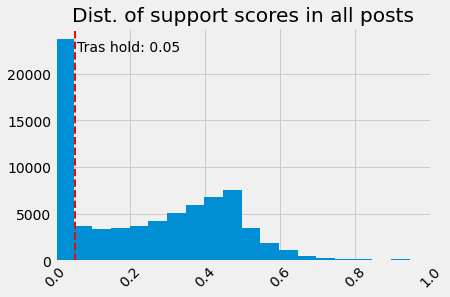

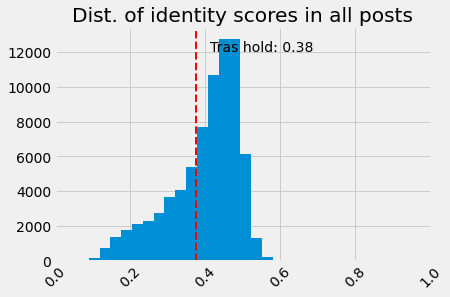

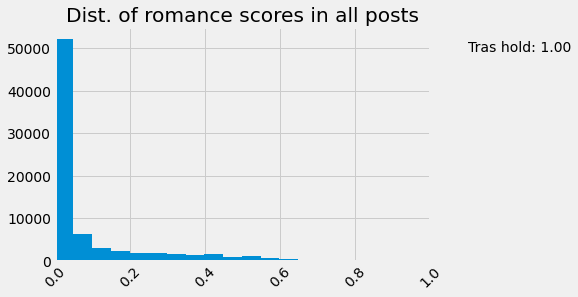

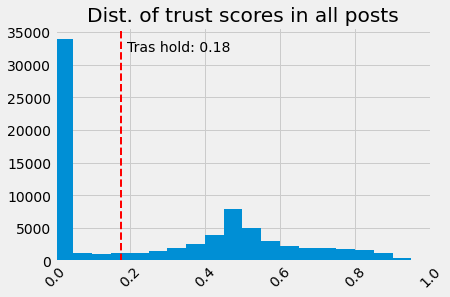

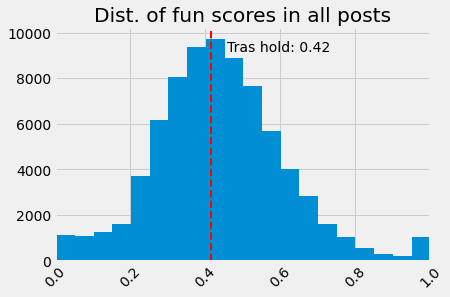

<Figure size 432x288 with 0 Axes>

In [42]:
trash_holds = {}   
for dim in dims:

    p_list = list(merged_posts[dim])
    ann_list,other_list = annotated_of_dim(dim, scores_per_dim, annotation_ratio= 0.5)
    pmean = 1
    if dim != 'romance':
        pmean = mean(ann_list)
    trash_holds[dim] = pmean        
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation= 45)
    plt.title(f'Dist. of {dim} scores in all posts')
    plt.xlim([0,1])
    plt.hist(p_list,bins=20)
    plt.axvline(pmean, color='red', linestyle='dashed', linewidth=2)
    min_ylim, max_ylim = plt.ylim()
    plt.text(pmean*1.1, max_ylim*0.9, 'Tras hold: {:.2f}'.format(pmean))
    plt.show()
    plt.clf()


In [43]:
with open('data/annotation/trash_holds.json','w') as f:
    json.dump(trash_holds,f)

In [44]:
trash_holds

{'conflict': 0.4307594341891152,
 'similarity': 0.25042258473959833,
 'knowledge': 0.7951832256864669,
 'power': 0.2077113337193926,
 'status': 0.3232280425727367,
 'support': 0.0542994892224669,
 'identity': 0.37557719512419263,
 'romance': 1,
 'trust': 0.17556890451442433,
 'fun': 0.41641424761878115}